# Four-Step Travel Demand Modeling for a Synthetic City with 5 Zones

**Author**: Md. Muhtashim Shahrier  
**Date**: March 2025  


## Overview

This notebook implements the complete four-step urban transportation modeling process for a synthetic 5-zone city. It includes:

1. **Trip Generation** – Using regression-based equations to estimate productions and attractions based on synthetic socio-economic data.
2. **Trip Distribution** – Applying a doubly-constrained gravity model with travel time impedance and iterative balancing.
3. **Mode Choice** – Estimating mode shares using a simple utility-based model.
4. **Traffic Assignment** – Assigning trips to network links using all-or-nothing or shortest-path algorithms.

Key features:
- Fully synthetic dataset
- Custom impedance function: `f(cij) = 1 / tij²`
- Convergence criteria to balance O-D matrix
- Modular code structure with clear documentation

The project is intended as a demonstration of theoretical understanding and practical implementation of the four-step modeling framework, commonly taught in Urban Transport Planning courses like CE 457 at BUET.

The idea for this project came from a term final exam question in CE 457 (Transport Planning). I extended it by completing all four modeling steps and implementing it in Python.


## Setup and Imports

All necessary Python libraries are imported in this section. These include:

- `pandas` and `numpy` for data manipulation
- `networkx` for any network-based operations (used later in traffic assignment)
- `matplotlib` for optional visualizations


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Trip Generation

In this section, I have created a synthetic dataset for 5 zones using the following socio-economic indicators:

- Number of cars
- Number of households
- Employment
- Commercial area (sq. meters)

The goal is to estimate trip **productions** and **attractions** using linear regression-style equations commonly used in trip generation modeling.

The equations used are:

- **Production**:  
 Pi = 30 + 2 × (Number of Cars) + 1 × (Number of Households)
- **Attraction**:  
  Aj = 10 + 1.4 × (Employment) + 0.04 × (Commercial Area)

The output below shows the computed production and attraction values for each zone based on these equations.



In [ ]:
# Socioeconomic Data of the 5 Zones
raw_data = {
    'Number of Cars' : [280, 220, 200, 180, 190],
    'Number of Households' : [200, 150, 140, 130, 110],
    'Employment' : [420, 560, 500, 210, 220],
    'Commercial Area' : [4100, 800, 700, 500, 600]
}

df = pd.DataFrame(raw_data, index = ["Zone A", "Zone B", "Zone C", "Zone D", "Zone E"])

# Calculations of Productions and Attractions
df["Productions"] = 30 + 2 * df["Number of Cars"] + df["Number of Households"]
df["Attractions"] = 10 + 1.4 * df["Employment"] + 0.04 * df["Commercial Area"]
df["Productions"] = df["Productions"].astype("float")
df["Attractions"] = df["Attractions"].astype("float")
df

,Number of Cars,Number of Households,Employment,Commercial Area,Productions,Attractions
Zone A,280,200,420,4100,790.0,762.0
Zone B,220,150,560,800,620.0,826.0
Zone C,200,140,500,700,570.0,738.0
Zone D,180,130,210,500,520.0,324.0
Zone E,190,110,220,600,520.0,342.0


### Summary

Total Productions: 3020
Total Attractions: 2974

The total productions and attractions are nearly balanced, allowing for smooth transition into the next step: trip distribution.


## Trip Distribution

In this section, I have applied the **doubly-constrained gravity model** to estimate the origin-destination (O-D) trip matrix based on the previously computed productions and attractions.

- The impedance function is defined as:
f(cij) = 1 / (tij)^2
  
  where tij is the travel time between zones \( i \) and \( j \)

- A synthetic travel time matrix is used to calculate the impedance between zones.

- An iterative balancing process is used to satisfy both row (production) and column (attraction) constraints, ensuring that the marginal totals converge within a small threshold (epsilon = 0.05).

The final output is a balanced O-D matrix that aligns with the specified productions and attractions across all zones.


In [ ]:
# Extracting productions and attractions
Oi = np.array(df["Productions"])
Dj = np.array(df["Attractions"])

# Defining synthetic travel time matrix
Travel_time = np.array([[2,12,7,8,14],
                       [13,3,19,6,10],
                       [9,16,4,7,12],
                       [8,6,7,3,5],
                       [14,10,12,5,4]])


In [ ]:
# Calculate impedance function: f(cij) = 1 / tij²
f = 1/Travel_time**2
f = np.round(f, 4)
print(f)

[[0.25   0.0069 0.0204 0.0156 0.0051]
 [0.0059 0.1111 0.0028 0.0278 0.01  ]
 [0.0123 0.0039 0.0625 0.0204 0.0069]
 [0.0156 0.0278 0.0204 0.1111 0.04  ]
 [0.0051 0.01   0.0069 0.04   0.0625]]


In [ ]:
# Balancing productions and attractions by upscaling the lower one
if np.sum(Oi) > np.sum(Dj):
    Dj *= np.sum(Oi) / np.sum(Dj)
else:
    Oi *= np.sum(Dj) / np.sum(Oi)

In [ ]:
# Doubly-constrained gravity model with iterative balancing
T = np.zeros((len(Oi), len(Dj)), dtype=float)
Djx = Dj.copy()
R = np.ones(len(Dj))
epsilon = 0.05

while True:
    for i in range(len(Oi)):
        m = 0
        for j in range(len(Dj)):
            m += Djx[j] * f[i][j]
        for j in range(len(Dj)):
            T[i][j] = Oi[i] * Djx[j] * f[i][j] / m

    for j in range(len(Dj)):
        col_sum = sum(T[i][j] for i in range(len(Oi)))
        R[j] = Dj[j] / col_sum

    if np.all(np.abs(R - 1) < epsilon):
        break

    Djx *= R

# Converting final matrix to labeled DataFrame
zone_labels = df.index
T_df = pd.DataFrame(np.round(T), index=zone_labels, columns=zone_labels)

print("Final Trip Distribution Matrix (T):")
print(T_df)


Final Trip Distribution Matrix (T):
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A   650.0    28.0    89.0    16.0     8.0
Zone B    19.0   534.0    15.0    34.0    18.0
Zone C    52.0    25.0   442.0    34.0    17.0
Zone D    51.0   139.0   111.0   143.0    76.0
Zone E    32.0    95.0    71.0    97.0   225.0


### Summary

The final trip distribution matrix has been successfully computed using the doubly-constrained gravity model. The matrix balances both the total number of trips produced and attracted by each zone, while accounting for travel time-based impedance.

This completes the Trip Distribution stage. The next step is Mode Choice.


## Mode Choice

In this section, I have estimated the probability of travelers choosing between two modes of transportation: **Auto** and **Transit**. The choice is based on a simplified utility model using travel time and cost for each mode.

The utility equations used are:

- U_Auto = 2.5 - 0.5 × Cost_Auto - 0.01 × TravelTime_Auto  
- U_Transit = -0.4 × Cost_Transit - 0.012 × TravelTime_Transit

The probability of choosing Auto is given by the logit model:

$$
P_{\text{Auto}} = \frac{e^{U_{\text{Auto}}}}{e^{U_{\text{Auto}}} + e^{U_{\text{Transit}}}}
$$

The probability of choosing Transit is:

$$
P_{\text{Transit}} = 1 - P_{\text{Auto}}
$$

These probabilities are applied element-wise to the O-D matrix from the previous step to split total trips into Auto and Transit trips.


In [ ]:
# Defining travel time and cost matrices for Auto and Transit modes (in minutes and currency units)
TT_Auto = np.array([[4,12,7,14,9],
                    [13,5,6,17,10],
                    [15,5,6,12,8],
                    [18,11,6,7,7],
                    [10,12,9,5,6]], dtype="float")

CT_Auto = np.array([[0.8,1.0,1.4,1.7,1.5],
                    [1.3,0.7,1.2,1.6,1.4],
                    [1.5,1.0,0.9,1.5,1.3],
                    [1.8,1.4,1.1,0.8,1.2],
                    [1.3,1.5,1.2,1.0,0.9]], dtype="float")

TT_Transit = np.array([[5,5,12,18,15],
                    [6,6,11,22,16],
                    [20,9,7,17,13],
                    [23,15,10,8,12],
                    [14,17,13,8,7]], dtype="float")

CT_Transit = np.array([[1.2,1.5,2.0,2.2,1.9],
                    [1.6,1.3,1.7,2.3,2.0],
                    [2.2,1.4,1.1,1.9,1.7],
                    [2.5,2.0,1.6,1.2,1.8],
                    [1.7,2.1,1.6,1.4,1.1]], dtype="float")


In [ ]:
# Converitng Matrix into labeled DataFrame
TT_Auto_df = pd.DataFrame(TT_Auto, index=zone_labels, columns=zone_labels)
CT_Auto_df = pd.DataFrame(CT_Auto, index=zone_labels, columns=zone_labels)
TT_Transit_df = pd.DataFrame(TT_Transit, index=zone_labels, columns=zone_labels)
CT_Transit_df = pd.DataFrame(CT_Transit, index=zone_labels, columns=zone_labels)
print("Travel Time Matrix - Auto (minutes):")
print(TT_Auto_df)
print("\nCost Matrix - Auto (units):")
print(CT_Auto_df)
print("\nTravel Time Matrix - Transit (minutes):")
print(TT_Transit_df)
print("\nCost Matrix - Transit (units):")
print(CT_Transit_df)

Travel Time Matrix - Auto (minutes):
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A     4.0    12.0     7.0    14.0     9.0
Zone B    13.0     5.0     6.0    17.0    10.0
Zone C    15.0     5.0     6.0    12.0     8.0
Zone D    18.0    11.0     6.0     7.0     7.0
Zone E    10.0    12.0     9.0     5.0     6.0

Cost Matrix - Auto (units):
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A     0.8     1.0     1.4     1.7     1.5
Zone B     1.3     0.7     1.2     1.6     1.4
Zone C     1.5     1.0     0.9     1.5     1.3
Zone D     1.8     1.4     1.1     0.8     1.2
Zone E     1.3     1.5     1.2     1.0     0.9

Travel Time Matrix - Transit (minutes):
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A     5.0     5.0    12.0    18.0    15.0
Zone B     6.0     6.0    11.0    22.0    16.0
Zone C    20.0     9.0     7.0    17.0    13.0
Zone D    23.0    15.0    10.0     8.0    12.0
Zone E    14.0    17.0    13.0     8.0     7.0

Cost Matrix - Transit (units):
        Zone A 

In [ ]:
# Calculating utilities for each mode based on cost and travel time
U_Auto = 2.5 - 0.5 * CT_Auto - 0.01 * TT_Auto
U_Transit = -0.4 * CT_Transit - 0.012 * TT_Transit

# Converting Matrix into labeled DataFrame
U_Auto_df = pd.DataFrame(U_Auto, index=zone_labels, columns=zone_labels)
U_Transit_df = pd.DataFrame(U_Transit, index=zone_labels, columns=zone_labels)

print("Utility Matrix – Auto:")
print(U_Auto_df)
print("\nUtility Matrix – Transit:")
print(U_Transit_df)

Utility Matrix – Auto:
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A    2.06    1.88    1.73    1.51    1.66
Zone B    1.72    2.10    1.84    1.53    1.70
Zone C    1.60    1.95    1.99    1.63    1.77
Zone D    1.42    1.69    1.89    2.03    1.83
Zone E    1.75    1.63    1.81    1.95    1.99

Utility Matrix – Transit:
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A  -0.540  -0.660  -0.944  -1.096  -0.940
Zone B  -0.712  -0.592  -0.812  -1.184  -0.992
Zone C  -1.120  -0.668  -0.524  -0.964  -0.836
Zone D  -1.276  -0.980  -0.760  -0.576  -0.864
Zone E  -0.848  -1.044  -0.796  -0.656  -0.524


In [ ]:
# Calculating Probabilities
exp_Auto = np.exp(U_Auto)
exp_Transit = np.exp(U_Transit)
P_Auto = exp_Auto / (exp_Auto + exp_Transit) # Could have also used Softmax
P_Transit = 1 - P_Auto

# Converting Matrix into labeled DataFrame
P_Auto_df = pd.DataFrame(P_Auto, index=zone_labels, columns=zone_labels)
P_Transit_df = pd.DataFrame(P_Transit, index=zone_labels, columns=zone_labels)

print("Probability Matrix – Auto:")
print(P_Auto_df)
print("\nProbability Matrix – Transit:")
print(P_Transit_df)

Probability Matrix – Auto:
          Zone A    Zone B    Zone C    Zone D    Zone E
Zone A  0.930862  0.926899  0.935475  0.931247  0.930862
Zone B  0.919235  0.936553  0.934134  0.937848  0.936553
Zone C  0.938197  0.932011  0.925117  0.930474  0.931247
Zone D  0.936790  0.935233  0.934011  0.931247  0.936672
Zone E  0.930733  0.935475  0.931247  0.931247  0.925117

Probability Matrix – Transit:
          Zone A    Zone B    Zone C    Zone D    Zone E
Zone A  0.069138  0.073101  0.064525  0.068753  0.069138
Zone B  0.080765  0.063447  0.065866  0.062152  0.063447
Zone C  0.061803  0.067989  0.074883  0.069526  0.068753
Zone D  0.063210  0.064767  0.065989  0.068753  0.063328
Zone E  0.069267  0.064525  0.068753  0.068753  0.074883


In [ ]:
# Spliting total trips into mode-specific matrix
T_Auto = T * P_Auto
T_Transit = T * P_Transit

# Converting Matrix into labeled DataFrame
T_Auto_df = pd.DataFrame(np.round(T_Auto), index=zone_labels, columns=zone_labels)
T_Transit_df = pd.DataFrame(np.round(T_Transit), index=zone_labels, columns=zone_labels)

print("Mode-Specific OD Matrix – Auto:")
print(T_Auto_df)
print("\nMode-Specific OD Matrix – Transit:")
print(T_Transit_df)


Mode-Specific OD Matrix – Auto:
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A   605.0    25.0    83.0    15.0     7.0
Zone B    17.0   500.0    14.0    32.0    17.0
Zone C    49.0    24.0   409.0    32.0    16.0
Zone D    48.0   130.0   104.0   133.0    71.0
Zone E    29.0    89.0    66.0    91.0   208.0

Mode-Specific OD Matrix – Transit:
        Zone A  Zone B  Zone C  Zone D  Zone E
Zone A    45.0     2.0     6.0     1.0     1.0
Zone B     1.0    34.0     1.0     2.0     1.0
Zone C     3.0     2.0    33.0     2.0     1.0
Zone D     3.0     9.0     7.0    10.0     5.0
Zone E     2.0     6.0     5.0     7.0    17.0


### Summary

The total O-D matrix has been split into Auto and Transit components using a simple utility-based mode choice model. These mode-specific matrices reflect relative travel cost and time, providing the basis for mode-sensitive traffic assignment in the next step.


## Traffic Assignment

In this section, I have performed an **all-or-nothing traffic assignment** using the Auto mode O-D matrix. The goal is to assign trip flows to network links based on the shortest path (minimum travel time) between origin-destination pairs.

- The O-D matrix is preprocessed by rounding and setting diagonal elements to zero (no intra-zonal trips).
- A synthetic undirected network is created using NetworkX, with specified travel times and link capacities.
- For each O-D pair, trips are assigned to the shortest time path using Dijkstra's algorithm.
- Total flows on each edge are computed by summing demands for all paths that include that edge.

Finally, the results are visualized with varying edge thickness to represent flow volume.


In [ ]:
# Preparing OD Matrix for Traffic Assignment
Traffic_Assignment = np.copy(np.round(T_Auto))
np.fill_diagonal(Traffic_Assignment, 0)
print(Traffic_Assignment)

[[  0.  25.  83.  15.   7.]
 [ 17.   0.  14.  32.  17.]
 [ 49.  24.   0.  32.  16.]
 [ 48. 130. 104.   0.  71.]
 [ 29.  89.  66.  91.   0.]]


In [ ]:
# Converting Matrix into Labeled DataFrame
zone_labels_up = ['A','B','C','D','E']
Traffic_Assignment_df = pd.DataFrame(Traffic_Assignment, index = zone_labels_up, columns = zone_labels_up)
print(Traffic_Assignment_df)

      A      B      C     D     E
A   0.0   25.0   83.0  15.0   7.0
B  17.0    0.0   14.0  32.0  17.0
C  49.0   24.0    0.0  32.0  16.0
D  48.0  130.0  104.0   0.0  71.0
E  29.0   89.0   66.0  91.0   0.0


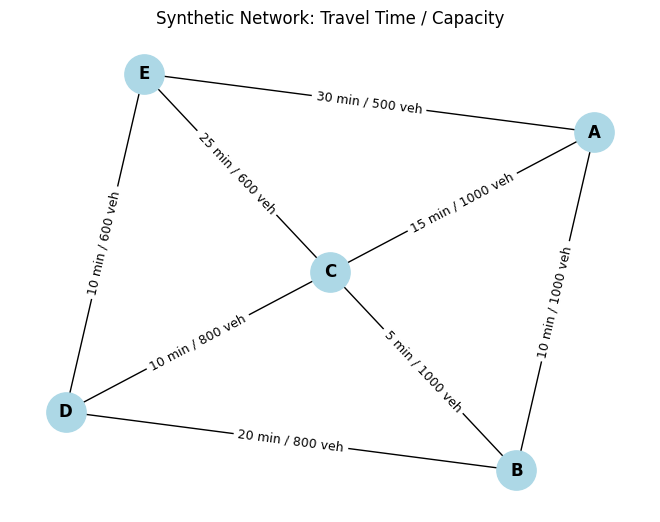

In [ ]:
# Defining and Visualizing the Network
G = nx.Graph()
G.add_nodes_from(zone_labels_up)

edges = [
    ('A', 'B', {'t0': 10, 'capacity': 1000}),
    ('A', 'C', {'t0': 15, 'capacity': 1000}),
    ('B', 'C', {'t0': 5,  'capacity': 1000}),
    ('B', 'D', {'t0': 20, 'capacity': 800}),
    ('C', 'D', {'t0': 10, 'capacity': 800}),
    ('C', 'E', {'t0': 25, 'capacity': 600}),
    ('D', 'E', {'t0': 10, 'capacity': 600}),
    ('E', 'A', {'t0': 30, 'capacity': 500}),
]
G.add_edges_from(edges)

pos = nx.spring_layout(G, seed=42)

nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=800, font_weight='bold')

edge_labels = {(u, v): f"{d['t0']} min / {d['capacity']} veh" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

plt.title("Synthetic Network: Travel Time / Capacity")
plt.show()

In [ ]:
# All or Nothing Assignment

from collections import defaultdict

# Initializing edge flow dictionary with default value 0
edge_flows = defaultdict(float)

for origin in Traffic_Assignment_df.index:
    for destination in Traffic_Assignment_df.columns:
        if origin != destination:
            demand = Traffic_Assignment_df.loc[origin, destination]
            path = nx.shortest_path(G, source=origin, target=destination, weight='t0') # Finding shortest path based on travel time
            for i in range(len(path) - 1):    # Assigning demand to each edge in the path
                u, v = path[i], path[i+1]
                edge = tuple(sorted((u, v)))
                edge_flows[edge] += demand

for edge, flow in edge_flows.items():
    print(f"{edge}: {flow:.1f} vehicles")

('A', 'B'): 42.0 vehicles
('A', 'C'): 195.0 vehicles
('C', 'D'): 549.0 vehicles
('A', 'E'): 36.0 vehicles
('B', 'C'): 306.0 vehicles
('D', 'E'): 350.0 vehicles


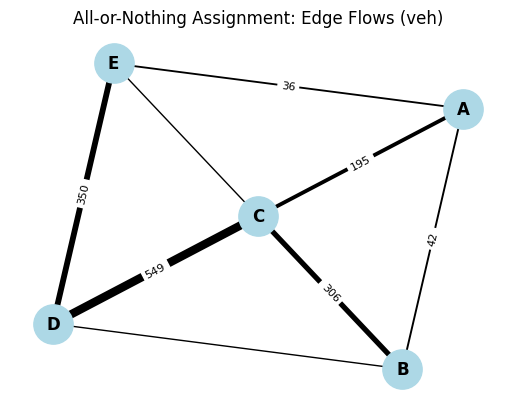

In [ ]:
pos = nx.spring_layout(G, seed=42)

# Using the maximum flow to normalize edge width
max_flow = max(edge_flows.values())
edge_widths = []

# Computing widths for each edge proportional to its flow
for u, v in G.edges():
    edge = tuple(sorted((u, v)))
    flow = edge_flows.get(edge, 0)
    width = 1 + (5 * flow / max_flow)
    edge_widths.append(width)

# Network Visualization
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800)
nx.draw_networkx_labels(G, pos, font_weight='bold')

nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='black')

edge_labels = {edge: f"{flow:.0f}" for edge, flow in edge_flows.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("All-or-Nothing Assignment: Edge Flows (veh)")
plt.axis('off')
plt.show()


### Summary

The all-or-nothing traffic assignment successfully assigns all Auto-mode trips to their shortest paths using travel time as the impedance. The final edge flows reflect total volume across the network. This provides a baseline for evaluating network performance under fixed demand assumptions.


## Final Summary

This project demonstrates a complete implementation of the four-step urban transportation planning model using synthetic data for a five-zone city. The model includes:

- **Trip Generation** using custom regression equations based on socio-economic indicators.
- **Trip Distribution** through a doubly-constrained gravity model with impedance based on travel time.
- **Mode Choice** using a simple utility-based logit model to split trips between Auto and Transit.
- **Traffic Assignment** with an all-or-nothing approach, allocating Auto trips along shortest-time paths in a synthetic network.

All steps are designed to be modular and reproducible, allowing easy experimentation or extension of individual components.

